# Titanic

This project uses machine learning with the Titanic dataset, specifically to preprocess the data, build models (Logistic Regression and Random Forest), and evaluate fairness in terms of gender and class. I also included visualizations of fairness metrics and SHAP for interpretability.

### Dataset

The Titanic dataset contains information about passengers aboard the ill-fated RMS Titanic, which sank in 1912. I used this dataset for binary classification, where the goal is to predict whether a passenger survived or not based on their characteristics.

Here’s a description of the key columns in the Titanic dataset:

- **PassengerId**: A unique identifier for each passenger.
- **Survived**: The target variable indicating whether the passenger survived (1) or not (0).
- **Pclass**: The class of the passenger (1, 2, or 3). This represents the socio-economic status of the passenger, with 1 being the highest class and 3 being the lowest.
- **Name**: The name of the passenger.
- **Sex**: The gender of the passenger (male/female).
- **Age**: The age of the passenger in years.
- **SibSp**: The number of siblings or spouses the passenger had aboard the Titanic.
- **Parch**: The number of parents or children the passenger had aboard the Titanic.
- **Ticket**: The ticket number of the passenger.
- **Fare**: The amount of money the passenger paid for the ticket.
- **Cabin**: The cabin number where the passenger stayed. Many values are missing.
- **Embarked**: The port where the passenger boarded the Titanic. C = Cherbourg, Q = Queenstown, S = Southampton.

This dataset is useful for building classification models to predict survival, where factors such as class, gender, age, and family status (SibSp, Parch) are common predictors. Data cleaning steps, such as handling missing values, encoding categorical data, and dealing with outliers, are often necessary for model training.

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, precision_recall_curve, 
    accuracy_score, classification_report
)
import shap

### 2. Load Data

In [2]:
# Load the dataset
csv_file_name = 'train.csv'
df = pd.read_csv(csv_file_name)

# Data Inspection
print("Dataset Info:")
print(df.info())
print("\nDataset Description:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Dataset Description:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523

### 3. Exploratory Data Analysis (EDA)

In [3]:
print("\nMissing Values in 'Cabin':", df['Cabin'].isnull().sum())
print("\nValue Counts for 'Embarked':")
print(df['Embarked'].value_counts())
print("\nNumber of Unique Classes in 'Pclass':", df['Pclass'].nunique())
print("\nPassenger Count by Class:")
print(df['Pclass'].value_counts())

# Group by 'Sex' and calculate mean values for 'Age', 'Fare', and 'Pclass'
print("\nMean Values by Sex:")
print(df.groupby('Sex')[['Age', 'Fare', 'Pclass']].mean(numeric_only=True))

# Group by 'Sex' and 'Pclass' and calculate mean 'Age'
print("\nMean Age by Sex and Class:")
print(df.groupby(['Sex', 'Pclass'])['Age'].mean())


Missing Values in 'Cabin': 687

Value Counts for 'Embarked':
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

Number of Unique Classes in 'Pclass': 3

Passenger Count by Class:
Pclass
3    491
1    216
2    184
Name: count, dtype: int64

Mean Values by Sex:
              Age       Fare    Pclass
Sex                                   
female  27.915709  44.479818  2.159236
male    30.726645  25.523893  2.389948

Mean Age by Sex and Class:
Sex     Pclass
female  1         34.611765
        2         28.722973
        3         21.750000
male    1         41.281386
        2         30.740707
        3         26.507589
Name: Age, dtype: float64


### 4. Preprocess the Data

In [4]:
# Data Preprocessing
# Drop unnecessary columns
df.drop(columns=['PassengerId', 'Ticket'], inplace=True)

# Extract titles from 'Name' and drop the 'Name' column
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
df.drop(columns=['Name'], inplace=True)

I handle missing values for the Age and Embarked columns using median and most frequent value imputation, respectively.

In [5]:
# Handle missing values
imputer_age = SimpleImputer(strategy='median')
df['Age'] = imputer_age.fit_transform(df[['Age']])

imputer_embarked = SimpleImputer(strategy='most_frequent')
df['Embarked'] = imputer_embarked.fit_transform(df[['Embarked']]).ravel()

I created new features like Children, Has_Cabin, FamilySize, and Fare_Bin to help the model, and you've converted categorical variables like Sex and Embarked into numerical format.

In [6]:
# Feature Engineering
df['Children'] = (df['Age'] < 18).astype(int)
df['Has_Cabin'] = df['Cabin'].notna().astype(int)
df.drop(columns=['Cabin'], inplace=True)

df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['Fare_Bin'] = pd.qcut(df['Fare'], 4, labels=[1, 2, 3, 4])
df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})

# One-hot encoding for categorical columns
df = pd.get_dummies(df, columns=['Embarked', 'Title'], drop_first=True)

In [7]:
# Separate features (X) and target (y)
X = df.drop(columns=['Survived'])
y = df['Survived']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Children,Has_Cabin,FamilySize,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,0,3,1,22.0,1,0,7.2500,0,0,2,...,False,False,False,False,False,True,False,False,False,False
1,1,1,0,38.0,1,0,71.2833,0,1,2,...,False,False,False,False,False,False,True,False,False,False
2,1,3,0,26.0,0,0,7.9250,0,0,1,...,False,False,True,False,False,False,False,False,False,False
3,1,1,0,35.0,1,0,53.1000,0,1,2,...,False,False,False,False,False,False,True,False,False,False
4,0,3,1,35.0,0,0,8.0500,0,0,1,...,False,False,False,False,False,True,False,False,False,False


In [9]:
df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Children,Has_Cabin,FamilySize
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.361582,0.523008,0.381594,32.204208,0.126824,0.228956,1.904602
std,0.486592,0.836071,0.477990,13.019697,1.102743,0.806057,49.693429,0.332962,0.420397,1.613459
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,1.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,11.000000


#### Key Findings

**Survival Rate (Survived)**:
- The average survival rate is 38.38%, meaning about 38% of passengers survived.
- This is a binary feature, so the mean represents the proportion of survivors.

**Passenger Class (Pclass)**:
- The average passenger class is 2.31, indicating that most passengers were in 2nd or 3rd class.
- 50% of passengers were in 3rd class.

**Gender (Sex)**:
- The mean is 0.65, indicating that about 65% of passengers were male (1 = male, 0 = female).

**Age (Age)**:
- The average age is 29.36 years, with a range from 0.42 to 80 years.
- 50% of passengers are between 22 and 35 years old.

**Siblings/Spouses (SibSp)**:
- The average number of siblings/spouses aboard is 0.52, with a maximum of 8.

**Parents/Children (Parch)**:
- The average number of parents/children aboard is 0.38, with a maximum of 6.

**Fare (Fare)**:
- The average fare is 32.20, but the standard deviation is 49.69, indicating high variability.
- 75% of passengers paid 31.00 or less, but the maximum fare is 512.33.

**Children (Children)**:
- The mean is 0.13, indicating that about 13% of passengers were children (Age < 18).

**Has Cabin (Has_Cabin)**:
- The mean is 0.23, indicating that about 23% of passengers had a cabin.

**Family Size (FamilySize)**:
- The average family size is 1.90, with a maximum of 11.

## 3. Build a Model

After splitting the data into training and testing sets, I train the Logistic Regression and Random Forest models, then evaluate their performance using accuracy, confusion matrix, and other classification metrics.

In [10]:
# Model Training and Evaluation
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Train and evaluate a model, returning predictions and metrics."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    return y_pred

# Initialize models
logreg_model = LogisticRegression(random_state=42)
rf_model = RandomForestClassifier(random_state=42)

# Train and evaluate models
y_pred_logreg = train_and_evaluate_model(logreg_model, X_train, y_train, X_test, y_test, "Logistic Regression")
y_pred_rf = train_and_evaluate_model(rf_model, X_train, y_train, X_test, y_test, "Random Forest")

Logistic Regression Accuracy: 0.8436

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       110
           1       0.80      0.80      0.80        69

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

Random Forest Accuracy: 0.8045

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       110
           1       0.75      0.74      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



#### Interpretation

- **Model Performance**: The Logistic Regression model performs slightly better than the Random Forest model, with an accuracy of 84.36% compared to 80.45%.         Both models perform better for class 0 ("did not survive") than for class 1 ("survived"), as indicated by higher precision, recall, and F1-score for class 0.
                                                                                                                                                                                                                                   
- **Class Imbalance**: The dataset is imbalanced, with more instances of class 0 (110) than class 1 (69). This imbalance may explain why both models perform better for class 0.

- **Precision and Recall**: For both models, precision and recall are higher for class 0 than for class 1. This suggests that the models are better at identifying passengers who did not survive than those who did.

- **F1-Score**: The F1-score, which balances precision and recall, is higher for class 0 than for class 1 in both models. This indicates that the models are more reliable for predicting "did not survive" than "survived."

## 4. Fairness Evaluation with Aequitas

I calculate fairness metrics (True Positive Rate, False Positive Rate, Precision, Recall, and Accuracy) for both gender and passenger class, and display these metrics for better understanding.

In [11]:
# Fairness Evaluation
def calculate_group_metrics(y_true, y_pred, group_membership):
    """Calculate fairness metrics for different groups."""
    metrics = {}
    unique_groups = np.unique(group_membership)
    
    for group in unique_groups:
        mask = group_membership == group
        tn, fp, fn, tp = confusion_matrix(y_true[mask], y_pred[mask]).ravel()
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tpr
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        
        metrics[group] = {
            'true_positive_rate': tpr,
            'false_positive_rate': fpr,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy,
            'count': sum(mask)
        }
    
    return metrics

# Create results dataframe
results_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_logreg,  # Use Logistic Regression predictions
    'sex': X_test[:, X.columns.get_loc('Sex')],  # Extract 'Sex' column
    'pclass': X_test[:, X.columns.get_loc('Pclass')]  # Extract 'Pclass' column
})

# Calculate fairness metrics
gender_metrics = calculate_group_metrics(results_df['y_true'], results_df['y_pred'], results_df['sex'])
results_df['pclass_binned'] = pd.cut(results_df['pclass'], bins=[-np.inf, 1.5, 2.5, np.inf], labels=['First', 'Second', 'Third'])
class_metrics = calculate_group_metrics(results_df['y_true'], results_df['y_pred'], results_df['pclass_binned'])

# Display fairness metrics
print("\nGender Fairness Metrics:")
print(pd.DataFrame(gender_metrics).T.round(3))
print("\nClass Fairness Metrics:")
print(pd.DataFrame(class_metrics).T.round(3))


Gender Fairness Metrics:
           true_positive_rate  false_positive_rate  precision  recall  \
-1.346933               1.000                0.625      0.818   1.000   
 0.742427               0.417                0.043      0.714   0.417   

           accuracy  count  
-1.346933     0.836   61.0  
 0.742427     0.847  118.0  

Class Fairness Metrics:
       true_positive_rate  false_positive_rate  precision  recall  accuracy  \
First               0.797                0.127      0.797   0.797     0.844   

       count  
First  179.0  


#### Key Findings

- **Gender Fairnes**: The model is biased toward females, with a much higher recall (1.000) but also a much higher false positive rate (0.625). For males, the model has a lower recall (0.417) but a much lower false positive rate (0.043).

- **Class Fairness**: The model performs similarly across passenger classes, with reasonable precision, recall, and accuracy for first-class passengers.

- **Potential Bias**: The high false positive rate for females suggests that the model may be over-predicting survival for females, which could be problematic in real-world applications.

## 5. Visualize Disparities

I visualize the fairness metrics using bar charts and examine the disparity between groups (e.g., gender disparity in true positive rates).

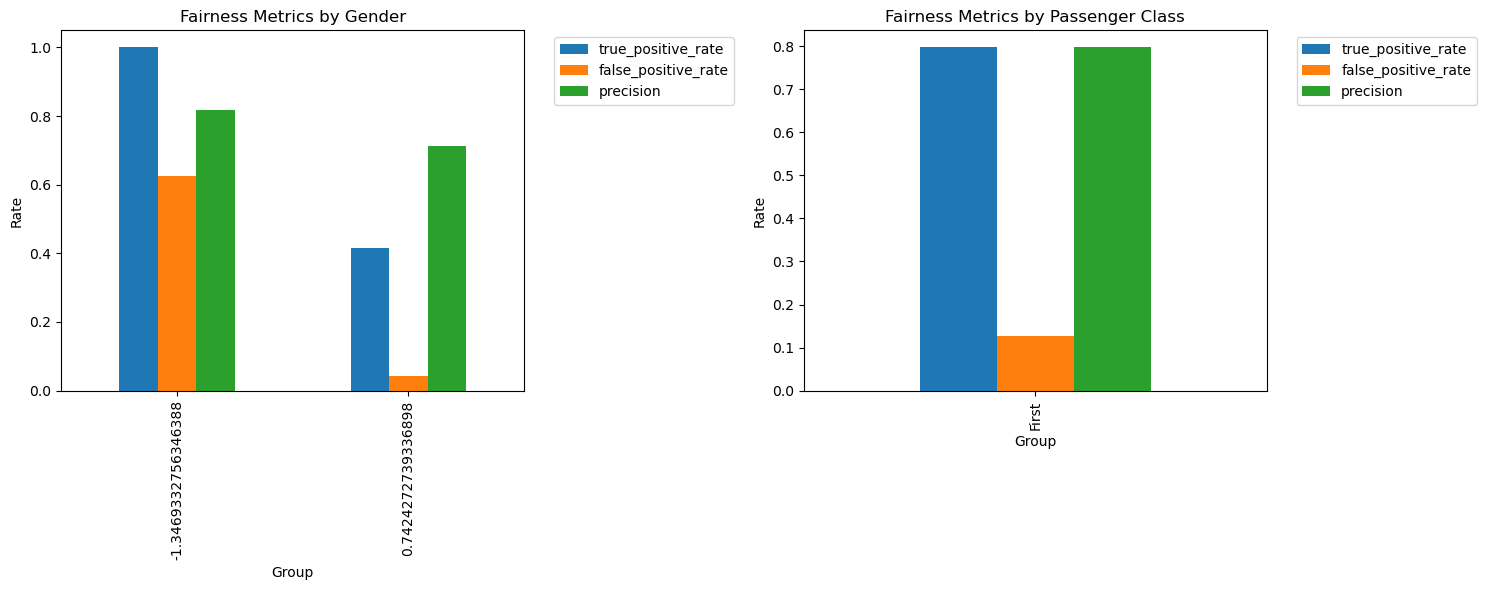

In [12]:
def plot_fairness_metrics(metrics, title, ax):
    """Plot fairness metrics (TPR, FPR, Precision) for a given group."""
    metrics_df = pd.DataFrame(metrics).T
    metrics_df.plot(kind='bar', y=['true_positive_rate', 'false_positive_rate', 'precision'], ax=ax, title=title)
    ax.set_xlabel('Group')
    ax.set_ylabel('Rate')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_fairness_metrics(gender_metrics, 'Fairness Metrics by Gender', ax1)
plot_fairness_metrics(class_metrics, 'Fairness Metrics by Passenger Class', ax2)
plt.tight_layout()
plt.show()

## 6. Interpret Model Predictions with SHAP

SHAP values are calculated to explain the model's feature importance, and confusion matrices are visualized for both models.

C:\Users\milto\anaconda3\Lib\site-packages\shap\explainers\_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


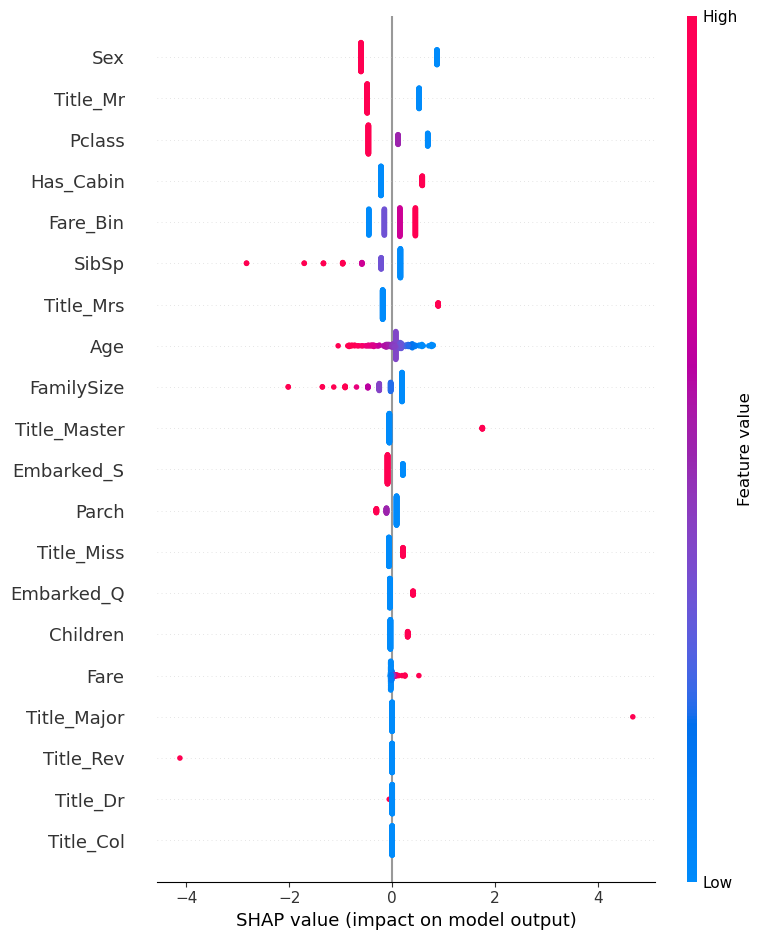

In [15]:
explainer = shap.LinearExplainer(logreg_model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

cm_logreg = confusion_matrix(y_test, y_pred_logreg)
cm_rf = confusion_matrix(y_test, y_pred_rf)

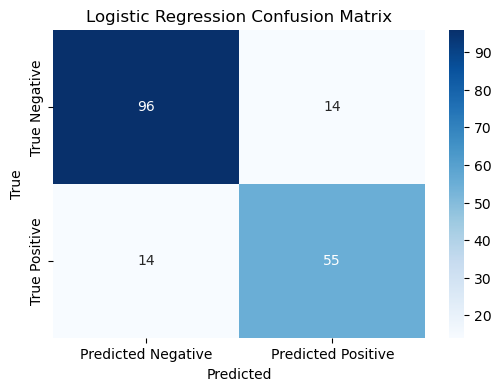

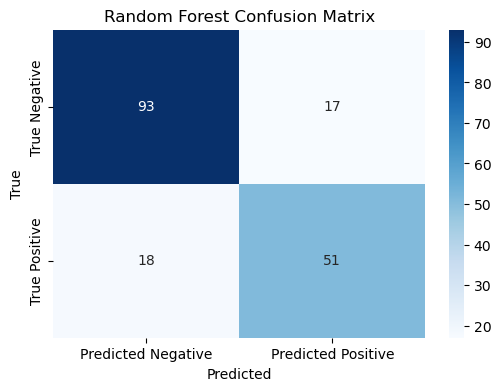

In [14]:
# Visualizing Confusion Matrix

# Compute confusion matrix for Logistic Regression and Random Forest
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Create a function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['True Negative', 'True Positive'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(cm_logreg, 'Logistic Regression')
plot_confusion_matrix(cm_rf, 'Random Forest')


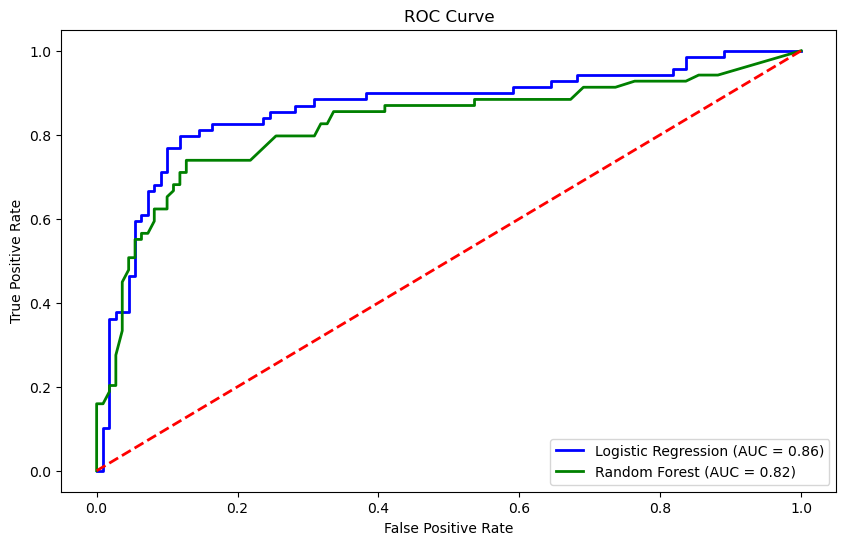

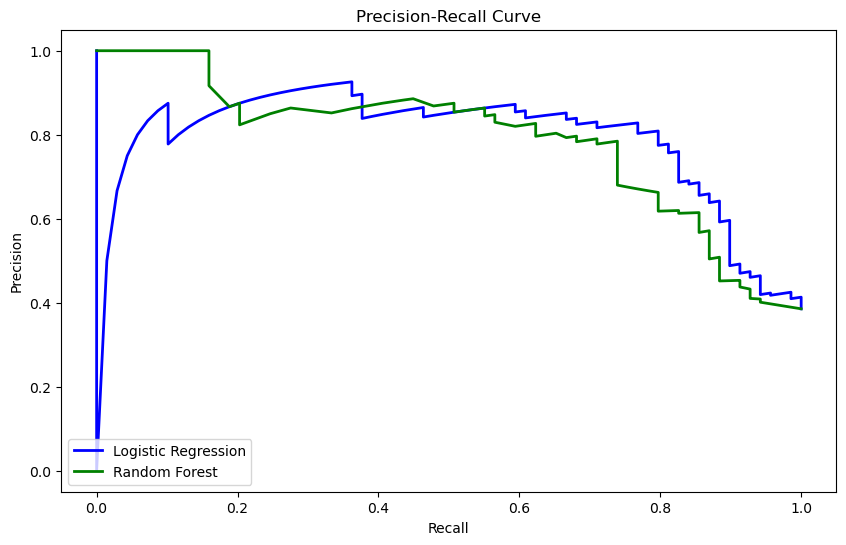

In [16]:
# ROC and Precision-Recall Curves
def plot_roc_curve(y_true, y_pred_proba, model_name, color):
    """Plot ROC curve for a given model."""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10, 6))
plot_roc_curve(y_test, logreg_model.predict_proba(X_test)[:, 1], 'Logistic Regression', 'blue')
plot_roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1], 'Random Forest', 'green')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

def plot_precision_recall_curve(y_true, y_pred_proba, model_name, color):
    """Plot Precision-Recall curve for a given model."""
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    plt.plot(recall, precision, color=color, lw=2, label=f'{model_name}')

plt.figure(figsize=(10, 6))
plot_precision_recall_curve(y_test, logreg_model.predict_proba(X_test)[:, 1], 'Logistic Regression', 'blue')
plot_precision_recall_curve(y_test, rf_model.predict_proba(X_test)[:, 1], 'Random Forest', 'green')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

### 7. Additional Fairness

Gender Fairness Metrics:
{'equalized_odds_difference': 0.5833333333333333, 'demographic_parity_difference': 0.7829952764656849, 'selection_rate': 0.3854748603351955}

Class Fairness Metrics:
{'equalized_odds_difference': 0.0, 'demographic_parity_difference': 0.0, 'selection_rate': 0.3854748603351955}

Gender MetricFrame:
           accuracy  true_positive_rate  false_positive_rate  selection_rate
sex                                                                         
-1.346933  0.836066            1.000000             0.625000        0.901639
 0.742427  0.847458            0.416667             0.042553        0.118644

Class MetricFrame:
               accuracy  true_positive_rate  false_positive_rate  \
pclass_binned                                                      
First          0.843575            0.797101             0.127273   

               selection_rate  
pclass_binned                  
First                0.385475  


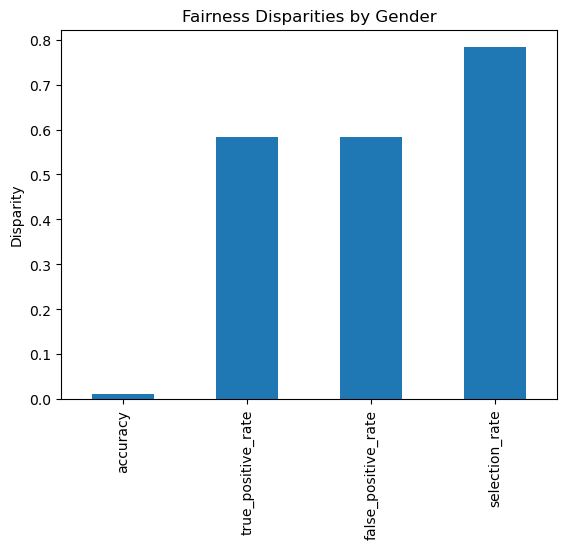

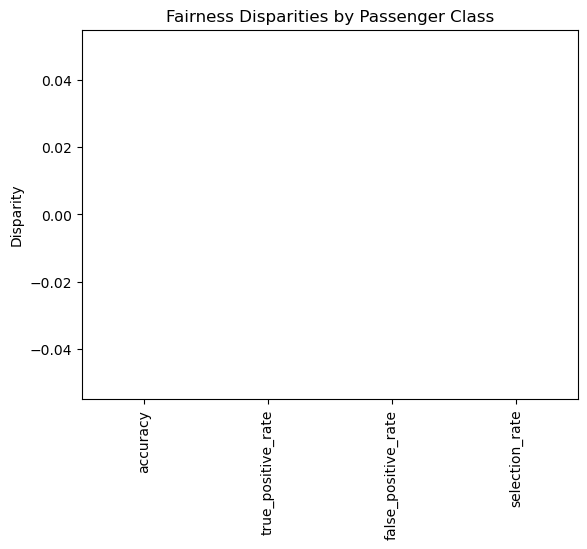


Gender Disparate Impact: 0.13158705701078582
Class Disparate Impact: 1.0


In [18]:
from fairlearn.metrics import (
    equalized_odds_difference, demographic_parity_difference, 
    selection_rate, MetricFrame
)
from sklearn.metrics import confusion_matrix

# Calculate additional fairness metrics
def calculate_fairness_metrics(y_true, y_pred, sensitive_features):
    """Calculate fairness metrics for a given sensitive feature."""
    metrics = {
        'equalized_odds_difference': equalized_odds_difference(
            y_true, y_pred, sensitive_features=sensitive_features
        ),
        'demographic_parity_difference': demographic_parity_difference(
            y_true, y_pred, sensitive_features=sensitive_features
        ),
        'selection_rate': selection_rate(y_true, y_pred)  # Overall selection rate
    }
    return metrics

# Calculate fairness metrics for gender
gender_fairness_metrics = calculate_fairness_metrics(
    results_df['y_true'], results_df['y_pred'], results_df['sex']
)

# Calculate fairness metrics for passenger class
class_fairness_metrics = calculate_fairness_metrics(
    results_df['y_true'], results_df['y_pred'], results_df['pclass_binned']
)

# Display fairness metrics
print("Gender Fairness Metrics:")
print(gender_fairness_metrics)
print("\nClass Fairness Metrics:")
print(class_fairness_metrics)

# Use MetricFrame for detailed fairness analysis
def calculate_metric_frame(y_true, y_pred, sensitive_features):
    """Calculate fairness metrics using MetricFrame."""
    metrics = {
        'accuracy': accuracy_score,
        'true_positive_rate': lambda y_true, y_pred: confusion_matrix(y_true, y_pred).ravel()[3] / (confusion_matrix(y_true, y_pred).ravel()[3] + confusion_matrix(y_true, y_pred).ravel()[2]),
        'false_positive_rate': lambda y_true, y_pred: confusion_matrix(y_true, y_pred).ravel()[1] / (confusion_matrix(y_true, y_pred).ravel()[1] + confusion_matrix(y_true, y_pred).ravel()[0]),
        'selection_rate': selection_rate
    }
    metric_frame = MetricFrame(
        metrics=metrics,
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )
    return metric_frame

# Calculate MetricFrame for gender
gender_metric_frame = calculate_metric_frame(
    results_df['y_true'], results_df['y_pred'], results_df['sex']
)

# Calculate MetricFrame for passenger class
class_metric_frame = calculate_metric_frame(
    results_df['y_true'], results_df['y_pred'], results_df['pclass_binned']
)

# Display MetricFrame results
print("\nGender MetricFrame:")
print(gender_metric_frame.by_group)
print("\nClass MetricFrame:")
print(class_metric_frame.by_group)

# Visualize fairness disparities
def plot_fairness_disparities(metric_frame, title):
    """Plot fairness disparities for a given MetricFrame."""
    disparities = metric_frame.difference()
    disparities.plot(kind='bar', title=title)
    plt.ylabel('Disparity')
    plt.show()

# Plot fairness disparities for gender
plot_fairness_disparities(gender_metric_frame, 'Fairness Disparities by Gender')

# Plot fairness disparities for passenger class
plot_fairness_disparities(class_metric_frame, 'Fairness Disparities by Passenger Class')

# Calculate and visualize disparate impact
def calculate_disparate_impact(y_true, y_pred, sensitive_features):
    """Calculate disparate impact for a given sensitive feature."""
    metric_frame = MetricFrame(
        metrics={'selection_rate': selection_rate},
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )
    selection_rates = metric_frame.by_group['selection_rate']
    disparate_impact = selection_rates.min() / selection_rates.max()
    return disparate_impact

# Calculate disparate impact for gender
gender_disparate_impact = calculate_disparate_impact(
    results_df['y_true'], results_df['y_pred'], results_df['sex']
)

# Calculate disparate impact for passenger class
class_disparate_impact = calculate_disparate_impact(
    results_df['y_true'], results_df['y_pred'], results_df['pclass_binned']
)

# Display disparate impact
print("\nGender Disparate Impact:", gender_disparate_impact)
print("Class Disparate Impact:", class_disparate_impact)

#### Interpetation

- **Gender Bias**: The model is highly biased toward females, with a much higher selection rate and false positive rate for females compared to males. This bias could lead to over-predicting survival for females and under-predicting survival for males.

- **Class Fairness**: The model performs fairly across passenger classes, with no significant disparities in selection rates or other metrics.

- **Disparate Impact**: The gender disparate impact value (0.1316) confirms the bias toward females. The class disparate impact value (1.0) confirms fairness across passenger classes.

## Conclusion

Two models—**Logistic Regression** and **Random Forest**—were trained and evaluated, with the Logistic Regression model achieving an accuracy of **84.36%** and the Random Forest model achieving **80.45%**.

The fairness analysis revealed significant disparities in model performance across genders. While the model performed exceptionally well for females, with a **true positive rate (recall) of 100%**, it exhibited a high false positive rate of 62.5%, indicating a tendency to over-predict survival for females who did not survive. In contrast, the model performed poorly for males, with a true positive rate of only 41.67% and a low false positive rate of 4.26%. This gender bias was further confirmed by the **demographic parity difference of 0.783** and the disparate impact value of 0.132, both of which indicate significant unfairness in the model's predictions.

In contrast, the model demonstrated fairness across passenger classes, with no significant disparities in true positive rates, false positive rates, or selection rates. The equalized odds difference and demographic parity difference for passenger class were both 0.0, and the disparate impact value was 1.0, indicating equitable performance across first, second, and third-class passengers.

To address the identified gender bias, future work should focus on **mitigating disparities** in model predictions. This could involve using fairness-aware algorithms, adjusting class weights, or incorporating additional features that better capture the underlying patterns in the data. Additionally, further analysis could explore fairness across other sensitive attributes, such as age groups or family size, to ensure the model performs equitably for all subgroups.